# Random forest p53 classification

In [1]:
## Imports

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


## 1. Loading the data

remove unnecessary quotes from csv files (result from edgeR)
```
tr -d '"' < meta_data_with_norm_factors.csv > meta.csv
tr -d '"' < count_data_EdgeR_preprocessed.csv > count.csv
```

In [2]:
dataset = pd.read_csv("Data/count.csv", index_col = 0)
metadata = pd.read_csv("Data/meta.csv", index_col = 0)

In [3]:
dataset.set_index('cases.0.samples.0.submitter_id', inplace=True, drop=True)
metadata.set_index('cases.0.samples.0.submitter_id', inplace=True, drop=True)

### Concatenate with labels

In [4]:
## Labels 
metadata = metadata[~metadata.index.duplicated(keep='first')] ## remove some duplicated rows

## Make sure that rows (samples) in the counts matrix (dataset) are in the same order as the metadata
dataset = dataset.loc[metadata.index]
## Add the class (1/0) as final column to the dataset
dataset['mutated'] = metadata.iloc[:,-2]

## 2. Spatial data simulation

In [7]:
def CreateSTSim(dataset, num_circles=6, grid_size=64, circle_radius=[4, 9], seed=None):
    # Set a seed for reproducibility if provided
    if seed is not None:
        np.random.seed(seed)

    # Create node features and labels
    node_features = np.zeros((grid_size, grid_size, len(dataset.columns) - 1))  # Node features
    node_labels = np.zeros((grid_size, grid_size), dtype=float)  # Node labels
    node_names = list()
    radii = np.random.randint(circle_radius[0], circle_radius[1], size=num_circles)  # random radii to define circle (clone) sizes within circle_radius limits
    circle_midpoints = np.random.randint(circle_radius[0], grid_size - circle_radius[0], size=(num_circles, 2))  # Define random circle midpoints within the grid size

    ## Split data into 1 and 0 class to make further processing faster
    data1 = dataset[dataset.iloc[:, -1] == 1]
    data0 = dataset[dataset.iloc[:, -1] == 0]
    # Assign class labels based on circle/clone location
    for i in range(grid_size):
        for j in range(grid_size):
            ## calculate distance between spot and each clone midpoint
            x = np.array([i, j])
            distances = np.linalg.norm(x - circle_midpoints, axis=1)
            if np.any(distances <= radii):
                ## if spot is within any clone (i.e., closer to the midpoint of the clone than the circle radius), assign class 1
                node_labels[i, j] = 1
                random_index = np.random.choice(len(data1.index))
                node_features[i, j] = data1.iloc[random_index, :-1].values
                node_names.append(data1.index[random_index])
            else:
                ## spot is outside a clone: class 0
                random_index = np.random.choice(len(data0.index))
                node_features[i, j] = data0.iloc[random_index, :-1].values
                node_names.append(data0.index[random_index])
    return node_features, node_labels, np.array(node_names).reshape(grid_size,grid_size)


In [8]:
grid_size = 64
features, labels, samples = CreateSTSim(dataset, num_circles = 6, grid_size = grid_size, circle_radius = [4,9],  seed = 1) ## Set seed for reproducibility

In [9]:
## make a grid of x and y coordinates
x, y = np.meshgrid(np.arange(grid_size), np.arange(grid_size), indexing='xy')

## 3. Random forest model

In [10]:
# Reshape the features to prepare for modeling
reshaped_features = features.reshape(-1, features.shape[2])  # Reshape to (n_samples, num_features)

# Flatten the labels
flattened_labels = labels.flatten()

# Flatten the coordinates
flattened_x = x.flatten()
flattened_y = y.flatten()

# Concatenate features and coordinates
combined_data = np.column_stack((reshaped_features, flattened_x, flattened_y))

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_data, flattened_labels, test_size=0.3, random_state=42)

In [13]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
# Predict on the test set
predictions = rf_classifier.predict(X_test)

Accuracy: 0.8836452400325467
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      1049
         1.0       0.85      0.25      0.39       180

    accuracy                           0.88      1229
   macro avg       0.87      0.62      0.66      1229
weighted avg       0.88      0.88      0.86      1229

Confusion Matrix:
[[1041    8]
 [ 135   45]]


## 4. Evaluation

In [16]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Additional evaluation metrics
print("Classification Report:")
print(classification_report(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))



Accuracy: 0.8836452400325467
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      1049
         1.0       0.85      0.25      0.39       180

    accuracy                           0.88      1229
   macro avg       0.87      0.62      0.66      1229
weighted avg       0.88      0.88      0.86      1229

Confusion Matrix:
[[1041    8]
 [ 135   45]]


## 5. Visualisations

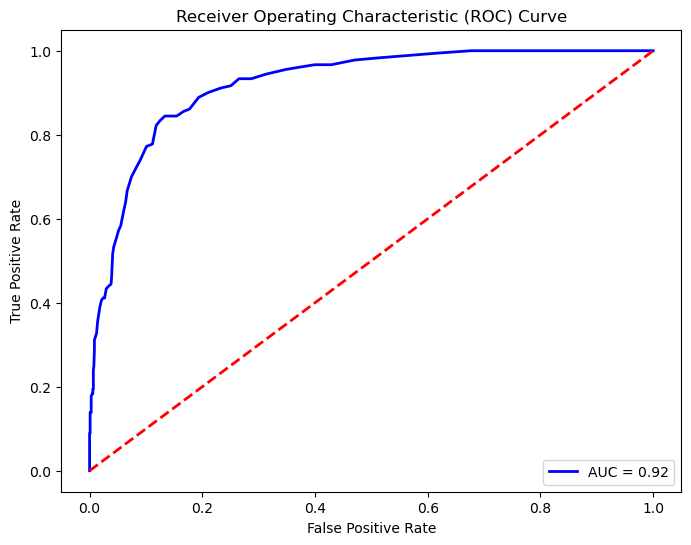

In [17]:
# Get predicted probabilities
probs = rf_classifier.predict_proba(X_test)
preds = probs[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


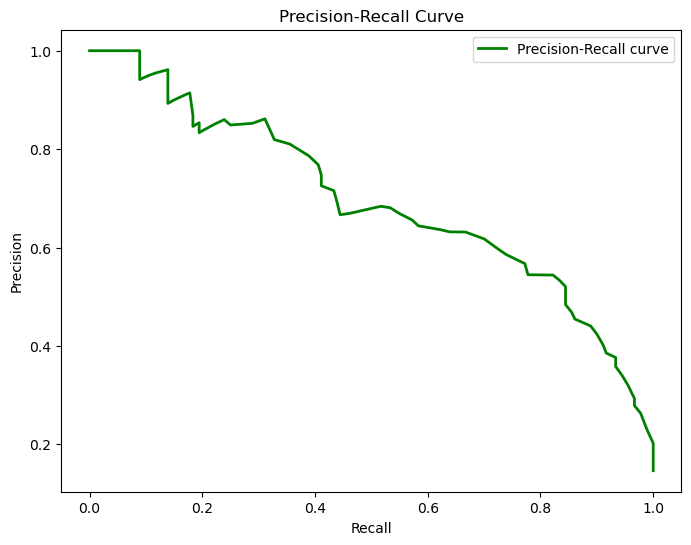

In [18]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, preds)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


IndexError: index 14197 is out of bounds for axis 0 with size 14196

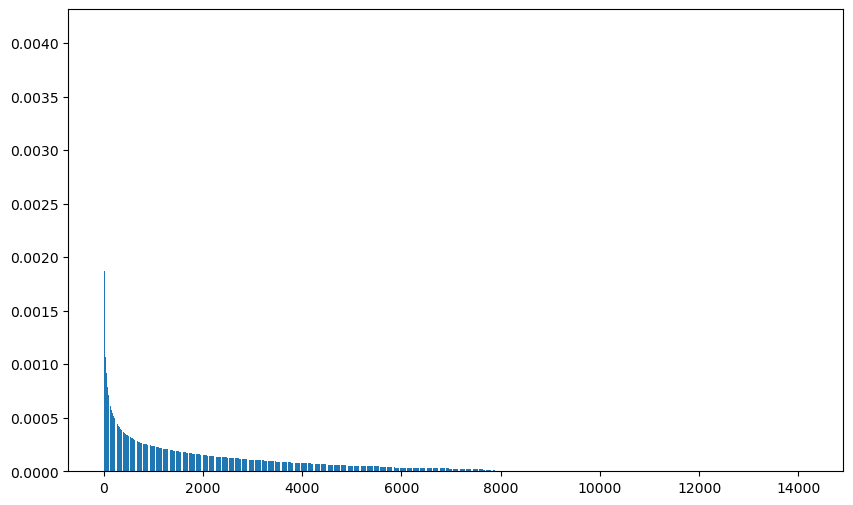

In [19]:
feature_importances = rf_classifier.feature_importances_
feature_names = dataset.columns[:-1]  # Excluding the target variable
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


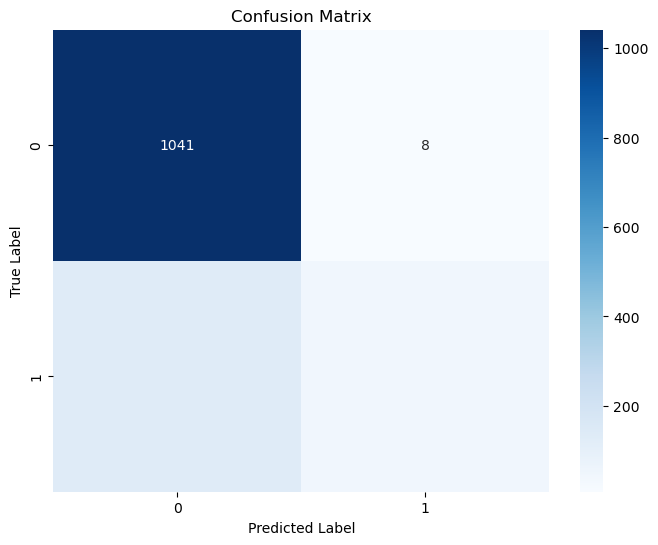

In [20]:
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
